#Загрузка необходимых библиотек

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 32.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN
from tensorflow.keras.applications.vgg19 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Создание класса обученной модели

In [ ]:
class FaceModel:
    """Класс FaceModel используется для классификации эмоции
    Используется детектор MT-CNN
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    predict(image)
        Принимает на вход изображение и возвращает эмоцию
    detect_face(image)
        На вход изображение и возвращает: 
        1) Маркер True - если есть лицо, False - если нет.
        2) Изображение обрезанное по bounding box (остается только лицо).
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = MTCNN()  # инициализируем детектор

    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def detect_face(self, image):
        detect = self.detector.detect_faces(image)
        total_idx = 0  # индекс box
        if len(detect) == 0:  # если box - не найден, отправим маркер False
            return False, image
        else:
            total_idx = 0
            if len(detect) > 1:
                # если несколько лиц на изображении, выбираем box с наибольшей площадью - как основу
                total_square = detect[total_idx]['box'][2] * detect[total_idx]['box'][3]
                for idx_box in range(1, len(detect)):
                    square_box = detect[idx_box]['box'][2] * detect[idx_box]['box'][3]
                    if square_box > total_square:
                        total_idx = idx_box
                        total_square = square_box
            # если один box, его индекс остается равным 0
            x_img, y_img, width_img, height_img = detect[total_idx]['box']
            # вырезаем изображение по границам box
            img_new = image[y_img:y_img+height_img, x_img:x_img+width_img, :]
            return True, img_new

    def predict(self, image):
        emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                        5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        _, img_face = self.detect_face(image)
        img_inp = self.preprocess_image(img_face)
        if _:
            pred = np.argmax(self.model.predict(img_inp[None,...]))  # индекс эмоции с наибольшей вероятностью
            name_emotion = emotion_indx[pred]
            return name_emotion
        else:
            return 'neutral'  # если лица нет на изображении - оставим "нейтральную" эмоцию


In [ ]:
model = FaceModel('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog')

#Загрузка тестовых данных

In [ ]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/test_kaggle.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
test_dir = Path().parent / "test_kaggle"
count_file = os.listdir(test_dir)  # создаем список файлов в папке

In [ ]:
df = pd.DataFrame(count_file, columns = ['image_path'])
df['sort'] = df['image_path'].apply(lambda x: int(x[:-4]))  # создадим колонку sort для сортировки изображений
df.sort_values(['sort'], ascending=True, inplace=True)
df.index = df['sort'].values
del df['sort']

##Проверим как работает модель

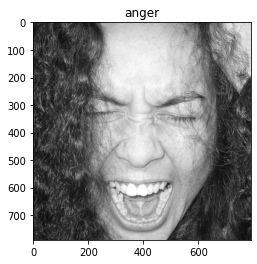

In [ ]:
img = cv2.imread("./test_kaggle/6.jpg")
plt.imshow(img)
plt.title(model.predict(img))
plt.show()

#Создаем файл .csv с прогнозом модели

In [ ]:
df['emotion'] = df['image_path'].apply(lambda x: model.predict(cv2.imread("./test_kaggle/" + x)))


In [ ]:
df.set_index('image_path', inplace=True)
df.to_csv("submission.csv")

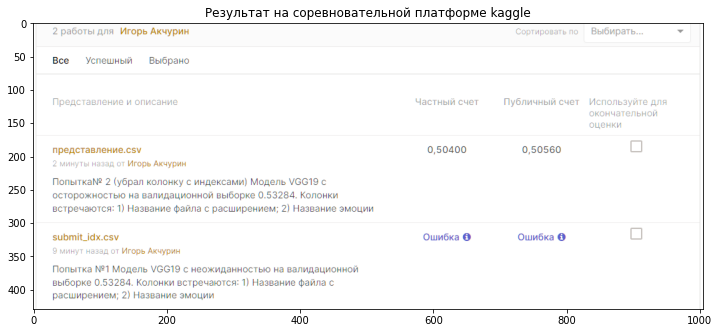

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Diplom/Out_kaggle.png")
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(img)
plt.title('Результат на соревновательной платформе kaggle')
plt.show()

#Результат на соревновательной платформе kaggle:</br>
Public Score – **0.50560**</br>
Private Score – **0.50400**</br>


#Проверим время инференса.

In [ ]:
# Загрузим обученную модель
model_load = tf.keras.models.load_model('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog')

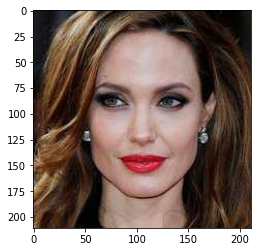

In [ ]:
img = cv2.cvtColor(cv2.imread("./1470.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
%%timeit -n 10 -r 10
model.predict(img)

10 loops, best of 10: 750 ms per loop


Скорость работы класса модели (детектирование лица + обработка изображения + предсказание) составляет 750 мс.

In [ ]:
detector = MTCNN()

In [ ]:
%%timeit -n 10 -r 10
detect = detector.detect_faces(img)
x, y, width, height = detect[0]['box']
img_new = img[y:y+height, x:x+width, :]
img_new = cv2.resize(img_new, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
img_new = preprocess_input(img_new)  # препроцессинг для VGG19

10 loops, best of 10: 487 ms per loop


487 мс - занимает обработка изображения

In [ ]:
%%timeit -n 10 -r 10
model_load.predict(img_new[None,...])

10 loops, best of 10: 267 ms per loop


267 мс - занимает время инференса самой модели, что соответствует условию задачи.

In [ ]:
%%timeit -n 10 -r 10
detect = detector.detect_faces(img)

10 loops, best of 10: 484 ms per loop


Детектор MTCNN занимает по времени 484 мс

In [ ]:
%%timeit -n 10 -r 10
x, y, width, height = detect[0]['box']
img_new = img[y:y+height, x:x+width, :]
img_new = cv2.resize(img_new, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
img_new = preprocess_input(img_new)  # препроцессинг для VGG19

The slowest run took 5.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 10: 268 µs per loop


Остальные операции преобразования выполняются не значительно по времени.

#Попробуем во время инференса использовать детектор в OpenCV

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
# иницилизируем детектор:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2022-08-13 19:29:49--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.004s  

2022-08-13 19:29:50 (243 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
%%timeit -n 10 -r 10
x_cv, y_cv, w_cv, h_cv = face_detector.detectMultiScale(img)[0]

10 loops, best of 10: 31.2 ms per loop


Детектор отработал более чем в 10 раз быстрее.

In [ ]:
img_cv_detect = img[y_cv:y_cv+h_cv, x_cv:x_cv+w_cv]

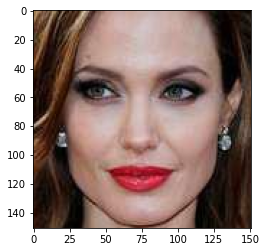

In [ ]:
plt.imshow(img_cv_detect)

Оценим в каком формате детектор определяет несколько лиц

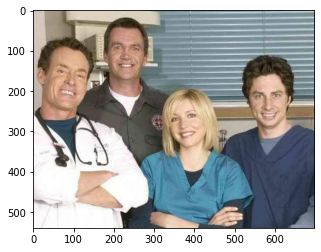

In [ ]:
img_prob = cv2.cvtColor(cv2.imread("./prob.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img_prob)

In [ ]:
detect_prob = face_detector.detectMultiScale(img_prob)

In [ ]:
print(detect_prob.shape)
detect_prob

(4, 4)


array([[181,  54, 101, 101],
       [527, 170, 111, 111],
       [ 24, 100, 135, 135],
       [317, 222, 115, 115]], dtype=int32)

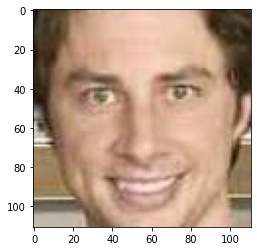

In [ ]:
plt.imshow(img_prob[170:170+111, 527:527+111])

Создадим новый класс модели, чтобы проверить точность определения эмоций на тестовой выборке

In [ ]:
class FaceModelCv:
    """Класс FaceModelCv используется для классификации эмоции
    Используется детектор основанный на методе Виолы-Джонсона и признаках Хаара
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    predict(image)
        Принимает на вход изображение и возвращает эмоцию
    detect_face(image)
        На вход изображение и возвращает: 
        1) Маркер True - если есть лицо, False - если нет.
        2) Изображение обрезанное по bounding box (остается только лицо).
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  # инициализируем детектор

    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def detect_face(self, image):
        detect = self.detector.detectMultiScale(image)
        total_idx = 0  # индекс box
        if len(detect) == 0:  # если box - не найден, отправим маркер False
            return False, image
        else:
            total_idx = 0
            if len(detect) > 1:
                # если несколько лиц на изображении, выбираем box с наибольшей площадью - как основу
                total_square = detect[total_idx][2] * detect[total_idx][3]
                for idx_box in range(1, len(detect)):
                    square_box = detect[idx_box][2] * detect[idx_box][3]
                    if square_box > total_square:
                        total_idx = idx_box
                        total_square = square_box
            # если один box, его индекс остается равным 0
            x_img, y_img, width_img, height_img = detect[total_idx]
            # вырезаем изображение по границам box
            img_new = image[y_img:y_img+height_img, x_img:x_img+width_img, :]
            return True, img_new

    def predict(self, image):
        emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                        5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        _, img_face = self.detect_face(image)
        img_inp = self.preprocess_image(img_face)
        if _:
            pred = np.argmax(self.model.predict(img_inp[None,...]))  # индекс эмоции с наибольшей вероятностью
            name_emotion = emotion_indx[pred]
            return name_emotion
        else:
            return 'neutral'  # если лица нет на изображении - оставим "нейтральную" эмоцию


In [ ]:
model_cv = FaceModelCv('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog')

Скорость без GPU

In [ ]:
%%timeit -n 10 -r 10
model_cv.predict(img)

10 loops, best of 10: 297 ms per loop


# Модель заметно ускорилась, осталось проверить - не потеряли ли мы в точности.

In [ ]:
df = pd.DataFrame(count_file, columns = ['image_path'])
df['sort'] = df['image_path'].apply(lambda x: int(x[:-4]))  # создадим колонку sort для сортировки изображений
df.sort_values(['sort'], ascending=True, inplace=True)
df.index = df['sort'].values
del df['sort']

In [ ]:
df['emotion'] = df['image_path'].apply(lambda x: model_cv.predict(cv2.imread("./test_kaggle/" + x)))

In [ ]:
df.set_index('image_path', inplace=True)
df.to_csv("submission.csv")

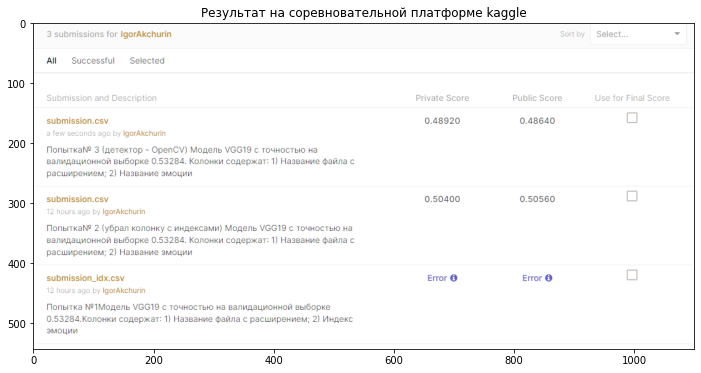

In [ ]:
img_out = cv2.imread("/content/drive/MyDrive/Diplom/Out_kaggle_cv.png")
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(img_out)
plt.title('Результат на соревновательной платформе kaggle')
plt.show()

Скорость на GPU:

In [ ]:
%%timeit -n 10 -r 10
model_cv.predict(img)

10 loops, best of 10: 74.9 ms per loop


#Результат на соревновательной платформе kaggle:</br>
Public Score – **0.48640**</br>
Private Score – **0.48920**</br>
</br></br>
Точность упала незначительно, а скорость модели с обработкой изображений стала, больше чем в 2 раза, быстрее и удовлетворять требованиям.</br>
Для оценки "5" достаточно > 0.4.</br>
С ускорителем GPU скорость составляет: 74.9 мс</br>
Без ускорителя GPU скорость составляет: 297 мс</br>
